In [29]:
import random
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

def synth_x(f, Ns, fs=256, mu=0, sigma=0):
    """
    generate a synthetic signal vector
    
    args:
    Ns [int]: number of samples (time samples)
    noise_power [float]: variance of WGN noise distribution
    """
    t = np.arange(0, Ns/fs, 1/fs)
    sine = np.sin(t*2*np.pi*f)
    return sine + np.random.normal(mu, sigma, sine.shape)

def synth_X(f, Nc, Ns, Nt=1, fs=256, mu=0, sigma=0):
    """
    Generate a matrix of several variations of the same target signal. This is used
    to simulate the measurement of a common signal over multiple EEG channels 
    that have different SNR characteristics.
    
    args:
    f [float]: target frequency of synthetic signal (Hz)
    Nc [int]: number of channels
    Ns [int]: number of samples (time samples)
    Ns [int]: number of iid trials
    noise_power [float]: variance of WGN noise distribution
    fs [float]: sampling frequency (Hz)
    f_std [float]: standard dev. of freq. in generated signal across channels to simulate interference from other frequency components over different channels
    """
    def _synth():
        X = []
        for i in range(Nc): # simulate noisy sinusoids with varying SNR across Nc channels
            f_i = f
            x = synth_x(f_i, Ns, fs=fs, mu=mu, sigma=sigma)

            X.append(x)

        return np.array(X)
    
    if Nt <= 1:
        return _synth()
    else:
        trials = []
        for i in range(Nt):
            trials.append(_synth().flatten())

        return np.array(trials)

def clean_results(g,m):
    for key, prob in g.items():
        g[key] = abs(prob)
    return max(g, key=g.get), max(m, key=m.get)

def retrieve_scores(gcca_total_res, mset_total_res):
    gcca_scores = {}
    mset_scores = {}

    for freq, decoded in gcca_total_res.items():
        gcca_scores[freq] = 0
        for result in decoded:
            if result[0] == freq:
                gcca_scores[freq]+=1
                
    for freq, decoded in mset_total_res.items():
        mset_scores[freq] = 0
        for result in decoded:
            if result[0] == freq:
                mset_scores[freq]+=1
    
    return gcca_scores, mset_scores

def generate_pure_sine_train(freqs, fs, trials):
    data = []
    for f in freqs:
        data.append((synth_X(f,1,fs,trials).T).reshape(1,fs,trials))
    return np.array(data)

def generate_pure_sine_test(f, fs, numTests):
    data = []
    for i in range(numTests):
        data.append(synth_x(f, fs, fs=fs, mu=0, sigma=0).reshape(1,fs))
    return data

def generate_noisy_sine_train(freqs, fs, trials, std):
    data = []
    for f in freqs:
        x = synth_X(f,1,fs,trials,mu=0,sigma=std)
        for i in range(len(x)):
            x[i] = (x[i] - x[i].mean())/x[i].std()
        data.append((x.T).reshape(1,fs,trials))
    return np.array(data)

def generate_noisy_sine_test(f, fs, numTests, std):
    data = []
    for i in range(numTests):
        data.append(synth_x(f, fs, fs=fs, mu=0, sigma=std).reshape(1,fs))
    return data



In [ ]:
x = synth_X(f,1,fs,trials)

In [ ]:
x = synth_x(1, 256, fs=256, mu=0, sigma=0)
for i in range(2,15):
    if i == 10:
        x+= 1*synth_x(10, 256, fs=256, mu=0, sigma=0)
    else:
        x+= synth_x(i, 256, fs=256, mu=0, sigma=0)
plt.plot(x)

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

freqs = [7,10,12]
fs=256
trials = 2

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

print(synth_X(7,1,256,trials).shape)
synth_7 = (synth_X(7,1,256,trials).T).reshape(1,fs,trials)
print(synth_7.shape)
synth_10 = (synth_X(10,1,256,trials).T).reshape(1,fs,trials)
synth_12 = (synth_X(12,1,256,trials).T).reshape(1,fs,trials)

train = np.array([synth_7, synth_10, synth_12])

print(train.shape)
gcca.fit(train)
mset_cca.fit(train)


gcca_res = gcca.classify(generate_pure_sine_test(7,256,10)[0])
mset_res = mset_cca.classify(generate_pure_sine_test(7,256,10)[0])

In [ ]:
for key, prob in gcca_res.items():
    gcca_res[key] = abs(prob)
print(max(gcca_res, key=gcca_res.get))
print(gcca_res)
print(max(mset_res, key=mset_res.get))
print(mset_res)

In [ ]:
gcca.fit(generate_noisy_sine_train([7,10,12],256,4,0))
gcca_res = gcca.classify(generate_noisy_sine_test(7,256,4,0)[0])

mset_cca.fit(generate_noisy_sine_train([7,10,12],256,4,10))
mset_res = mset_cca.classify(generate_noisy_sine_test(7,256,4,10)[0])

In [ ]:
for key, prob in gcca_res.items():
    gcca_res[key] = abs(prob)
print(max(gcca_res, key=gcca_res.get))
print(gcca_res)
print(max(mset_res, key=mset_res.get))
print(mset_res)

In [ ]:
plt.plot(generate_noisy_sine_test(7,256,4,0)[0].flatten())

# PURE SINE TESTS AND PLOT

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

freqs = [7,10,12]
fs= 256
trials = 4
numTests = 100

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

train = generate_pure_sine_train(freqs, fs, trials)
print(train.shape)
gcca.fit(train)
mset_cca.fit(train)

gcca_total_res = {}
mset_total_res = {}

for f in freqs:
    gcca_arr = []
    mset_arr = []
    tests = generate_pure_sine_test(f, fs, numTests)
    for test in tests:
        gcca_res = gcca.classify(test)
        mset_res = mset_cca.classify(test)
        g, m = clean_results(gcca_res,mset_res)
        gcca_arr.append((g,gcca_res))
        mset_arr.append((m,mset_res))
    gcca_total_res[f] = gcca_arr
    mset_total_res[f] = mset_arr
    
print(retrieve_scores(gcca_total_res, mset_total_res))

In [ ]:
print(gcca_total_res[7][0])
print(mset_total_res[7][0])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# fig2, ax = plt.subplots(nrows=3, ncols=1)

# ax1.plot()
# ax2.plot()
# ax3.plot()
# ax1.set_xlabel('Samples')
# ax2.set_xlabel('Samples')
# ax3.set_xlabel('Samples')

fig, axs = plt.subplots(3, sharex=True)
axs[0].plot(train[0,0,:,0])
axs[0].set_title('7 Hz Synthetic')
axs[1].plot(train[1,0,:,0])#,'tab:green'
axs[1].set_title('10 Hz Synthetic')
axs[2].plot(train[2,0,:,0])
axs[2].set_title('12 Hz Synthetic')

fig.tight_layout()

# NOISY SINE TESTS AND PLOT

## PURE TRAIN NOISY TEST

In [94]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

freqs = [7,10,12]
fs= 256
trials = 2
numTests = 100

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

results_over_std = []

train = generate_pure_sine_train(freqs, fs, trials)
print(train.shape)
gcca.fit(train)
mset_cca.fit(train)

for std in range(101):
    
    gcca_total_res = {}
    mset_total_res = {}

    for f in freqs:
        gcca_arr = []
        mset_arr = []
        tests = generate_noisy_sine_test(f, fs, numTests, std)
        for test in tests:
            test_standard = (test-test.mean())/test.std()
            gcca_res = gcca.classify(test_standard)
            mset_res = mset_cca.classify(test_standard)
            g, m = clean_results(gcca_res,mset_res)
            gcca_arr.append((g,gcca_res))
            mset_arr.append((m,mset_res))
        gcca_total_res[f] = gcca_arr
        mset_total_res[f] = mset_arr

    results_over_std.append(retrieve_scores(gcca_total_res, mset_total_res))

(3, 1, 256, 2)


In [95]:
results_per_freq = {'gcca_7':[],'gcca_10':[],'gcca_12':[],'mset_7':[],'mset_10':[],'mset_12':[]}
for i in results_over_std:
    results_per_freq['gcca_7'].append(i[0][7])
    results_per_freq['gcca_10'].append(i[0][10])
    results_per_freq['gcca_12'].append(i[0][12])
    results_per_freq['mset_7'].append(i[1][7])
    results_per_freq['mset_10'].append(i[1][10])
    results_per_freq['mset_12'].append(i[1][12])

Text(0.5, 0, 'Standard deviation')

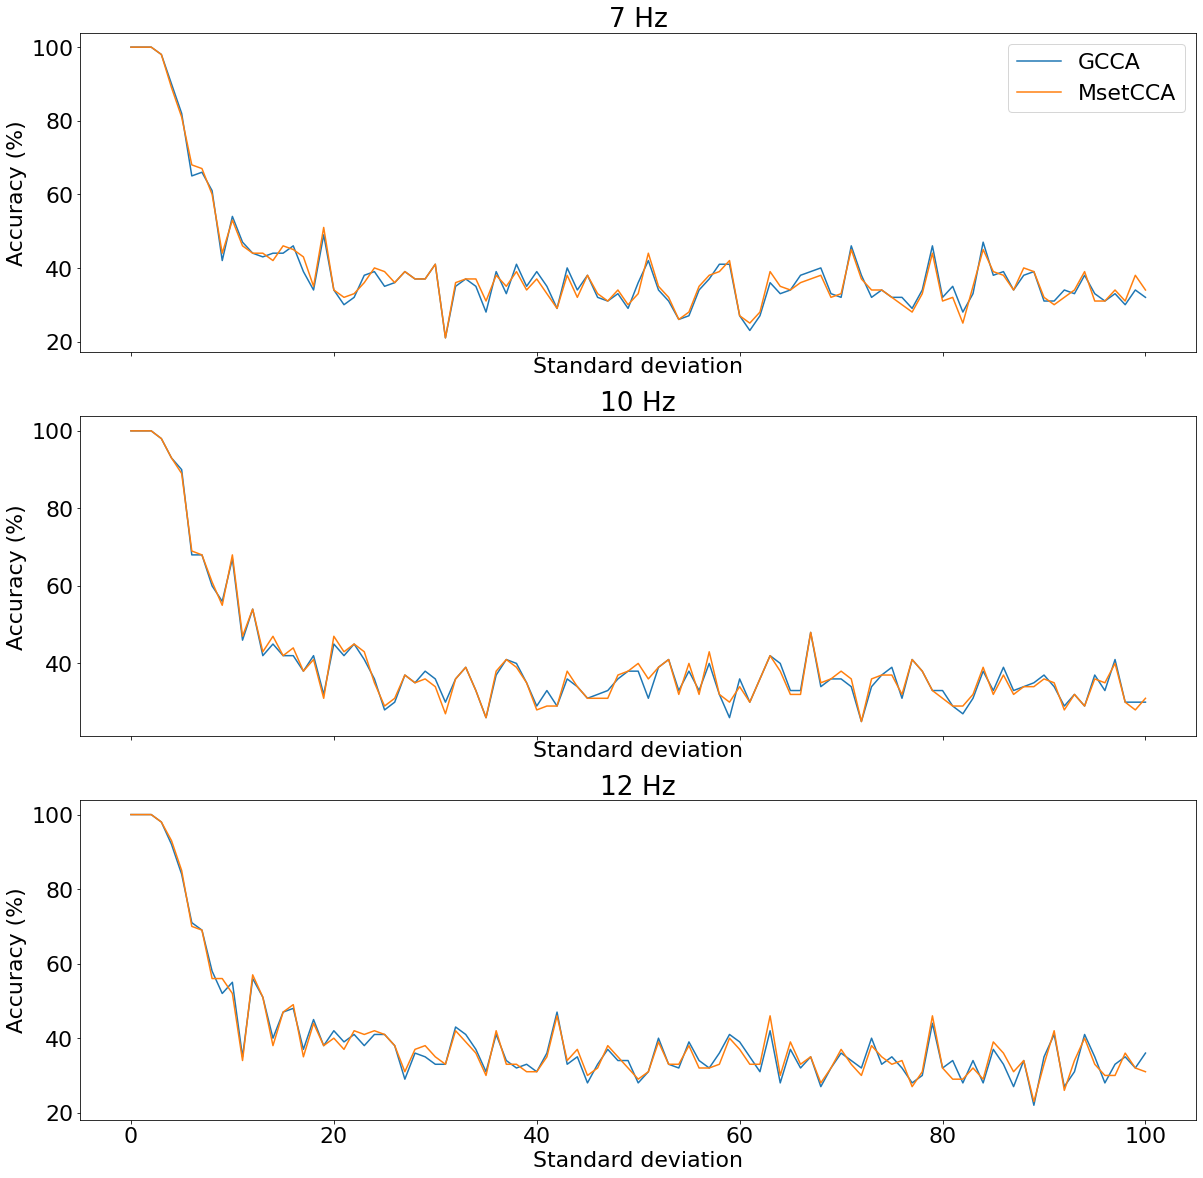

In [108]:
fig, axs = plt.subplots(3,1, figsize=(20,20), sharex=True)
axs[0].plot(results_per_freq['gcca_7'])
axs[0].plot(results_per_freq['mset_7'])
axs[0].set_xlabel('Standard deviation')
axs[0].legend(['GCCA','MsetCCA'])
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_title('7 Hz')
axs[1].plot(results_per_freq['gcca_10'])
axs[1].plot(results_per_freq['mset_10'])
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('10 Hz')
axs[1].set_xlabel('Standard deviation')
axs[2].plot(results_per_freq['gcca_12'])
axs[2].plot(results_per_freq['mset_12'])
axs[2].set_title('12 Hz')
axs[2].set_ylabel('Accuracy (%)')
axs[2].set_xlabel('Standard deviation')
# fig.tight_layout()

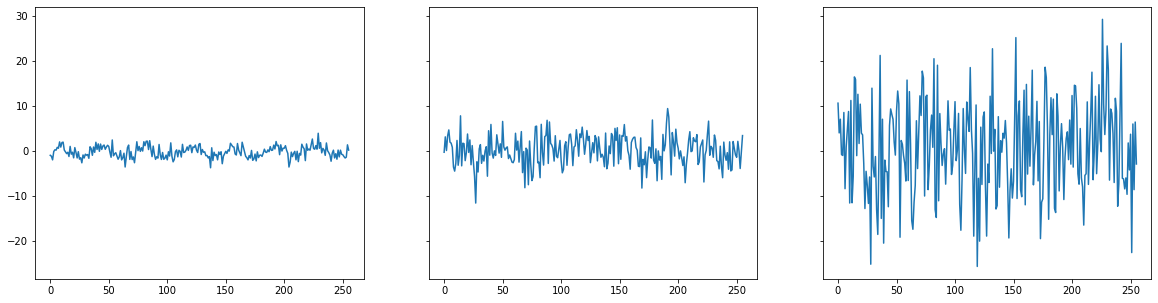

In [69]:
fig, axs = plt.subplots(1,3, figsize=(20,5), sharey=True)
axs[0].plot(generate_noisy_sine_test(7, 256, 1, 1)[0][0])
axs[1].plot(generate_noisy_sine_test(7, 256, 1, 3)[0][0])
axs[2].plot(generate_noisy_sine_test(7, 256, 1, 10)[0][0])

Text(0.5, 1.0, 'σ = 10')

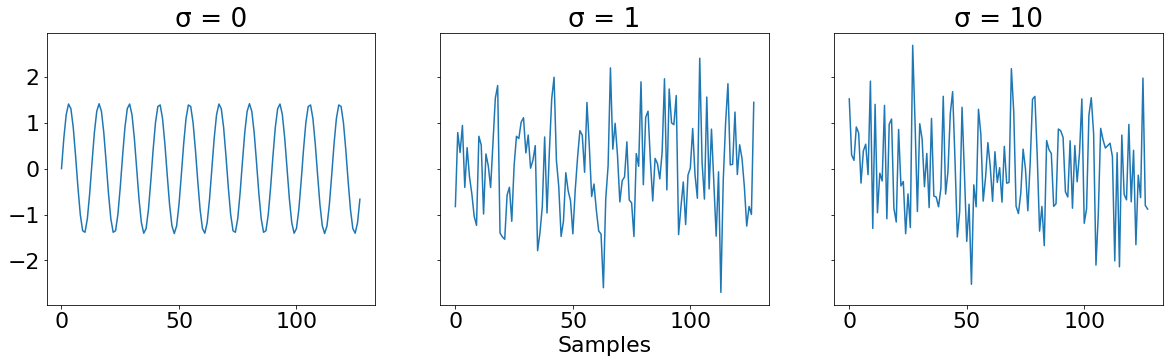

In [109]:
fig, axs = plt.subplots(1,3, figsize=(20,5), sharey=True)

a1 = generate_noisy_sine_test(10, 64, 1, 0)[0][0]
b1 = generate_noisy_sine_test(10, 64, 1, 1)[0][0]
c1 = generate_noisy_sine_test(10, 64, 1, 20)[0][0]

a = (a1-a1.mean())/a1.std()
b = (b1-b1.mean())/b1.std()
c = (c1-c1.mean())/c1.std()

axs[0].plot(a)
axs[1].plot(b)
axs[2].plot(c)

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(20,5), sharey=True)

axs[0].plot(a)
axs[0].set_title('\u03C3 = 0')
axs[1].plot(b)
axs[1].set_title('\u03C3 = 1')
axs[1].set_xlabel('Samples')
axs[2].plot(c)
axs[2].set_title('\u03C3 = 10')

## NOISY TRAIN PURE TEST

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

freqs = [7,10,12]
fs= 256
trials = 4
numTests = 1

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

results_over_std = []

for std in range(101):
    
    train = generate_noisy_sine_train(freqs, fs, trials, std)
    print(train.shape)
    gcca.fit(train)
    mset_cca.fit(train)
    gcca_total_res = {}
    mset_total_res = {}

    for f in freqs:
        gcca_arr = []
        mset_arr = []
        tests = generate_pure_sine_test(f, fs, numTests)
        for test in tests:
#             test_standard = (test-test.mean())/test.std()
            gcca_res = gcca.classify(test)
            mset_res = mset_cca.classify(test)
            g, m = clean_results(gcca_res,mset_res)
            gcca_arr.append((g,gcca_res))
            mset_arr.append((m,mset_res))
        gcca_total_res[f] = gcca_arr
        mset_total_res[f] = mset_arr

    results_over_std.append(retrieve_scores(gcca_total_res, mset_total_res))

In [37]:
results_per_freq = {'gcca_7':[],'gcca_10':[],'gcca_12':[],'mset_7':[],'mset_10':[],'mset_12':[]}
for i in results_over_std:
    results_per_freq['gcca_7'].append(i[0][7])
    results_per_freq['gcca_10'].append(i[0][10])
    results_per_freq['gcca_12'].append(i[0][12])
    results_per_freq['mset_7'].append(i[1][7])
    results_per_freq['mset_10'].append(i[1][10])
    results_per_freq['mset_12'].append(i[1][12])

Text(0.5, 0, 'Standard deviation of training data')

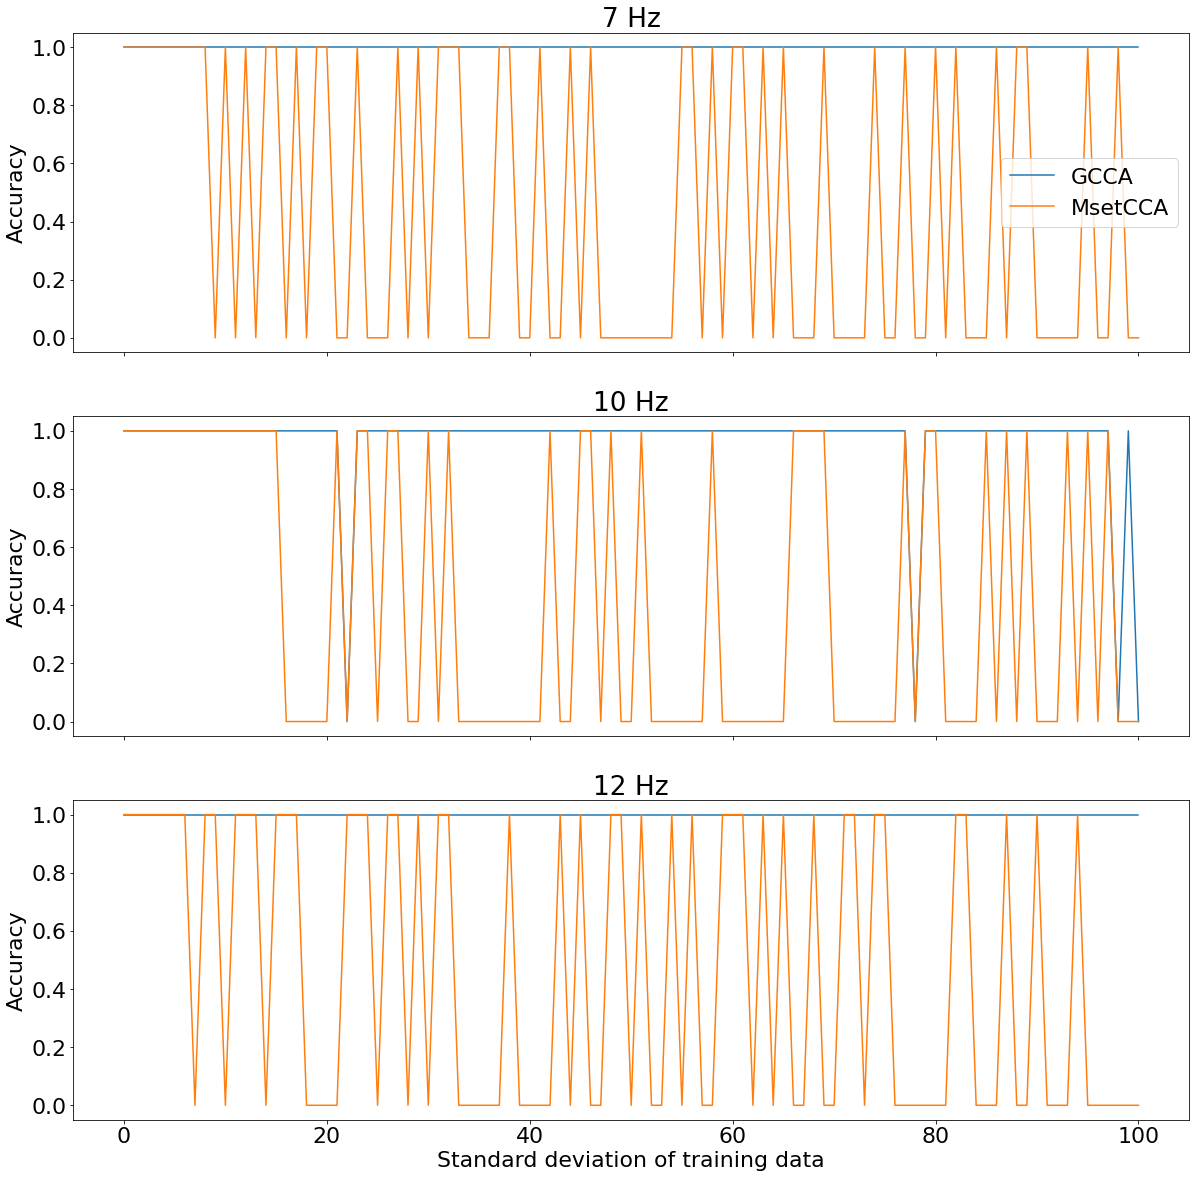

In [39]:
fig, axs = plt.subplots(3,1, figsize=(20,20), sharex=True)
plt.rcParams.update({'font.size': 22})
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
axs[0].plot(results_per_freq['gcca_7'])
axs[0].plot(results_per_freq['mset_7'])
axs[0].legend(['GCCA','MsetCCA'])
axs[0].set_ylabel('Accuracy')
axs[0].set_title('7 Hz')
axs[1].plot(results_per_freq['gcca_10'])
axs[1].plot(results_per_freq['mset_10'])
axs[1].set_ylabel('Accuracy')
axs[1].set_title('10 Hz')
axs[2].plot(results_per_freq['gcca_12'])
axs[2].plot(results_per_freq['mset_12'])
axs[2].set_title('12 Hz')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Standard deviation of training data')
# fig.tight_layout()

In [34]:
print(results_per_freq['gcca_7'].count(1))
print(results_per_freq['mset_7'].count(1))

print(results_per_freq['gcca_10'].count(1))
print(results_per_freq['mset_10'].count(1))

print(results_per_freq['gcca_12'].count(1))
print(results_per_freq['mset_12'].count(1))

101
38
99
54
101
51


In [8]:
results_per_freq

{'gcca_7': [100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  0,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100],
 'gcca_10': [100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,


In [9]:
gcca_total_res

{7: [(7,
   {7: 0.6911460909759279,
    10: 0.0002457196376971332,
    12: 0.004488024955309974}),
  (7,
   {7: 0.6911460909759279,
    10: 0.0002457196376971332,
    12: 0.004488024955309974}),
  (7,
   {7: 0.6911460909759279,
    10: 0.0002457196376971332,
    12: 0.004488024955309974}),
  (7,
   {7: 0.6911460909759279,
    10: 0.0002457196376971332,
    12: 0.004488024955309974}),
  (7,
   {7: 0.6911460909759279,
    10: 0.0002457196376971332,
    12: 0.004488024955309974}),
  (7,
   {7: 0.6911460909759279,
    10: 0.0002457196376971332,
    12: 0.004488024955309974}),
  (7,
   {7: 0.6911460909759279,
    10: 0.0002457196376971332,
    12: 0.004488024955309974}),
  (7,
   {7: 0.6911460909759279,
    10: 0.0002457196376971332,
    12: 0.004488024955309974}),
  (7,
   {7: 0.6911460909759279,
    10: 0.0002457196376971332,
    12: 0.004488024955309974}),
  (7,
   {7: 0.6911460909759279,
    10: 0.0002457196376971332,
    12: 0.004488024955309974}),
  (7,
   {7: 0.6911460909759279,
    

## NOISY TRAIN NOISY TEST

In [ ]:
from eeg_lib.cca import GCCA_SSVEP
from eeg_lib.cca import MsetCCA_SSVEP

freqs = [7,10,12]
fs= 256
trials = 4
numTests = 100

gcca = GCCA_SSVEP(freqs, fs, Nh=1)

mset_cca = MsetCCA_SSVEP(freqs)

results_over_std = []

for std in range(101):
    
    train = generate_noisy_sine_train(freqs, fs, trials,std)
    print(train.shape)
    gcca.fit(train)
    mset_cca.fit(train)
    gcca_total_res = {}
    mset_total_res = {}

    for f in freqs:
        gcca_arr = []
        mset_arr = []
        tests = generate_noisy_sine_test(f, fs, numTests,std)
        for test in tests:
            test_standard = (test-test.mean())/test.std()
            gcca_res = gcca.classify(test)
            mset_res = mset_cca.classify(test)
            g, m = clean_results(gcca_res,mset_res)
            gcca_arr.append((g,gcca_res))
            mset_arr.append((m,mset_res))
        gcca_total_res[f] = gcca_arr
        mset_total_res[f] = mset_arr

    results_over_std.append(retrieve_scores(gcca_total_res, mset_total_res))

In [44]:
results_per_freq = {'gcca_7':[],'gcca_10':[],'gcca_12':[],'mset_7':[],'mset_10':[],'mset_12':[]}
for i in results_over_std:
    results_per_freq['gcca_7'].append(i[0][7])
    results_per_freq['gcca_10'].append(i[0][10])
    results_per_freq['gcca_12'].append(i[0][12])
    results_per_freq['mset_7'].append(i[1][7])
    results_per_freq['mset_10'].append(i[1][10])
    results_per_freq['mset_12'].append(i[1][12])

Text(0.5, 0, 'Standard deviation of test and training data noise')

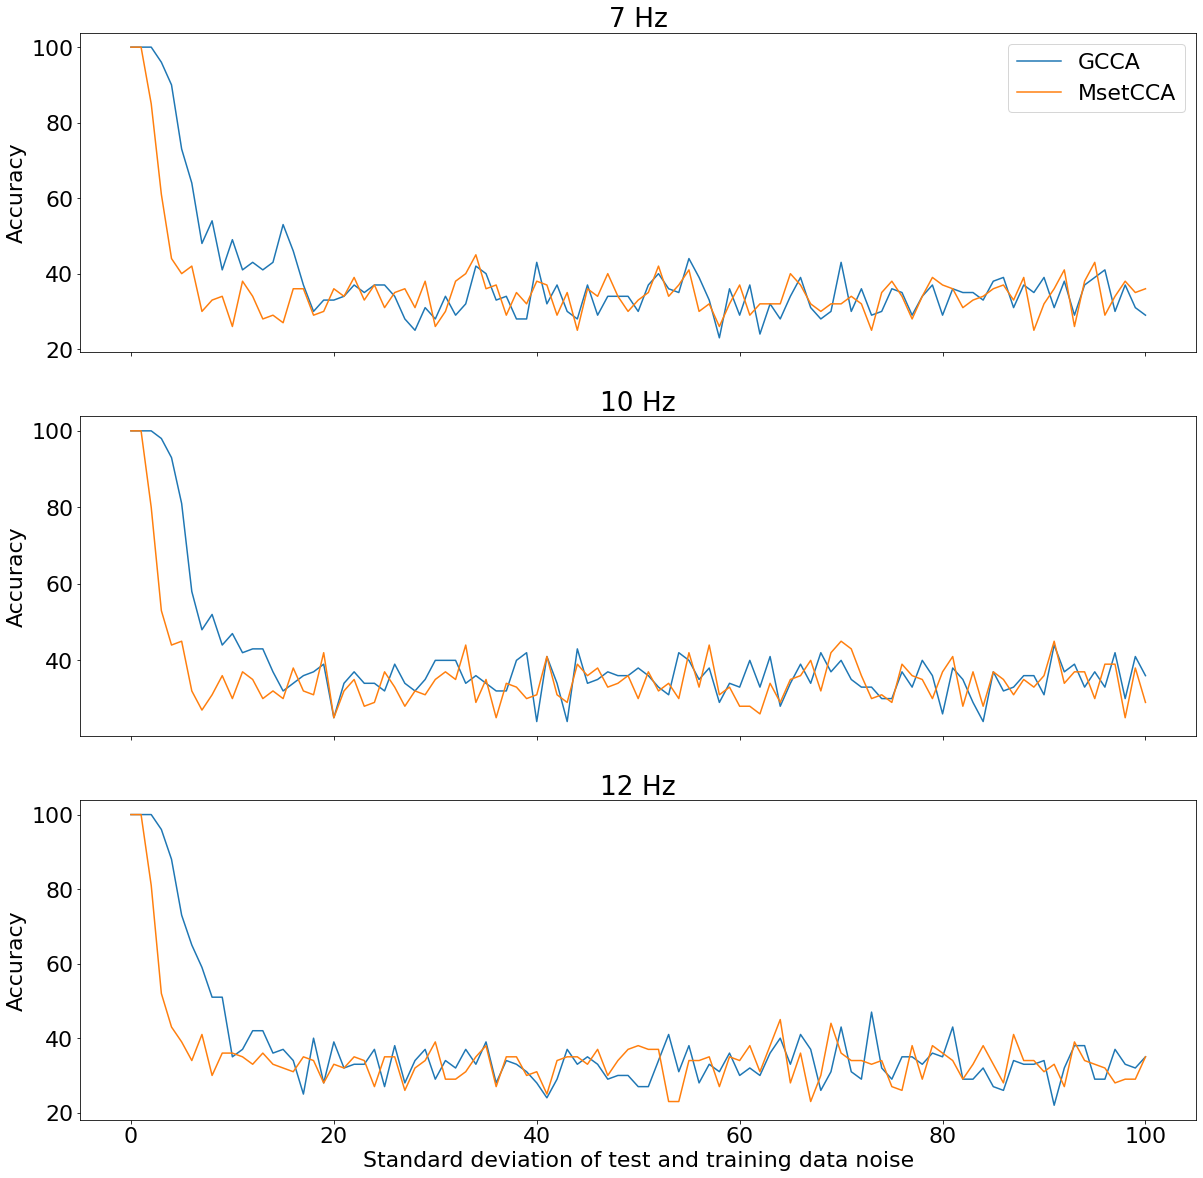

In [46]:
fig, axs = plt.subplots(3,1, figsize=(20,20), sharex=True)
plt.rcParams.update({'font.size': 22})
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
axs[0].plot(results_per_freq['gcca_7'])
axs[0].plot(results_per_freq['mset_7'])
axs[0].legend(['GCCA','MsetCCA'])
axs[0].set_ylabel('Accuracy')
axs[0].set_title('7 Hz')
axs[1].plot(results_per_freq['gcca_10'])
axs[1].plot(results_per_freq['mset_10'])
axs[1].set_ylabel('Accuracy')
axs[1].set_title('10 Hz')
axs[2].plot(results_per_freq['gcca_12'])
axs[2].plot(results_per_freq['mset_12'])
axs[2].set_title('12 Hz')
axs[2].set_ylabel('Accuracy')
axs[2].set_xlabel('Standard deviation of test and training data noise')
# fig.tight_layout()